In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray, rgb2hed
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy import ndimage as ndi

## Importing the data

In [170]:
train_df = pd.read_csv("train_metadata.csv")
test_df = pd.read_csv("test_metadata.csv")

train_files = train_df["ID"].to_list()
labels_train = train_df["label"].to_list()
test_files = test_df["ID"].to_list()


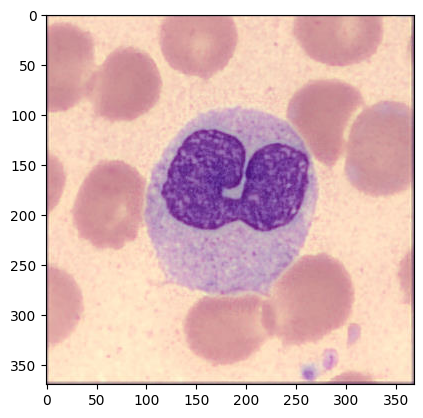

In [171]:
# Verifying if everything works
train_idx = np.random.randint(0, len(train_files))
X = io.imread(f"./train/{train_files[train_idx]}")
plt.imshow(X)

## Data Enhancement

## Segmentation #1 : Watershed (bad) 

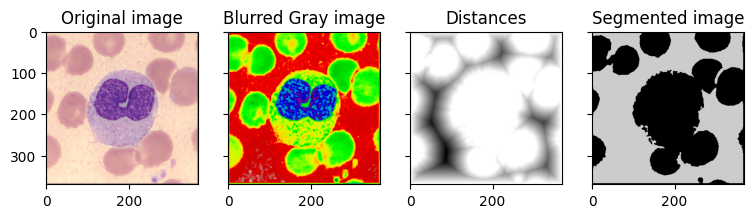

In [172]:
X_smooth = ndi.gaussian_filter(rgb2gray(X), 1.0)
def select_cell(X):
    thresh = threshold_otsu(X)
    X_mask = X > thresh
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels,distance = select_cell(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()

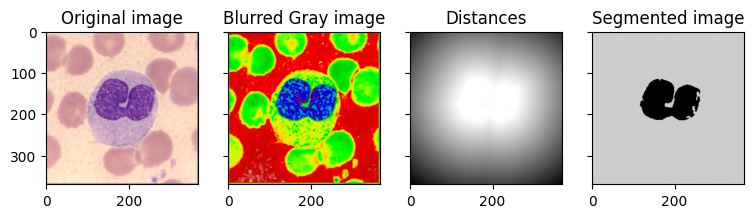

In [173]:
def select_nucleus(X):
    thresh = threshold_otsu(X)
    X_mask = X > 0.4
    X_mask = remove_small_objects(X_mask, min_size=5000)
    X_mask = remove_small_holes(X_mask, area_threshold=6500)
    distance = ndi.distance_transform_edt(X_mask)
    coords = peak_local_max(distance, footprint=np.ones((1, 1), dtype=bool), labels = X_mask.astype(bool))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=X_mask)
    return labels, distance

labels_nucleus, distance_nucleus = select_nucleus(X_smooth)
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(X_smooth, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Blurred Gray image')
ax[2].imshow(-distance_nucleus, cmap=plt.cm.gray)
ax[2].set_title('Distances')
ax[3].imshow(labels_nucleus, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Segmented image')

plt.show()